# Predicción del cáncer de próstata 

#### Datos

Consideramos un estudio médico realizado en 97 hombres con cáncer de próstata.
La atención se centra en la relación entre el antígeno prostático específico (PSA), que está elevado en los hombres con cáncer de próstata, y otras medidas clínicas. 
Las otras medidas clínicas son las variables predictoras, recogidas en un examen médico, y la cantidad de expresión del antígeno asociado a la detección del cáncer es la variable de respuesta (lpsa).

Así, el marco de datos está formado por 97 observaciones sobre 9 variables:
* LCAVOL: Volumen de cáncer logarítmico
* lPeso: log peso de la próstata
* Edad: edad del paciente en años
* lbph: cantidad logarítmica de hiperplasia prostática benigna
* SVI: invasión de vesículas seminales
* LCP: logaritmo de penetración capsular
* gleason: Puntuación de Gleason
* pgg45: porcentaje de la puntuación de Gleason 4 o 5
* LPSA: Antígeno prostático logarítmico específico

El objetivo es encontrar modelos que predigan la respuesta lpsa.

#### Modelos

Los datos se representan mediante puntos $n$ en dimensiones $p$, por lo que la variable predictora se escribe $X\in\mathbb{R}^{n\times p}$ y la variable de respuesta es $y\in\mathbb{R}^n$.

En este trabajo, nos interesa la relación entre el predictor $X$ y la respuesta $y$.
Para determinar esta relación, adoptamos modelos de regresión.

La línea base estándar se logra con regresión lineal y comparamos los resultados de las regresiones regularizadas: **Regresión de cresta**, **Lazo** y **Red elástica**.

In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns

## Data exploration

In [3]:
lpsa_data = pd.read_csv('data/prostate_dataset.txt', delimiter='\t')
lpsa_data = lpsa_data.loc[:, 'lcavol':]
lpsa_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


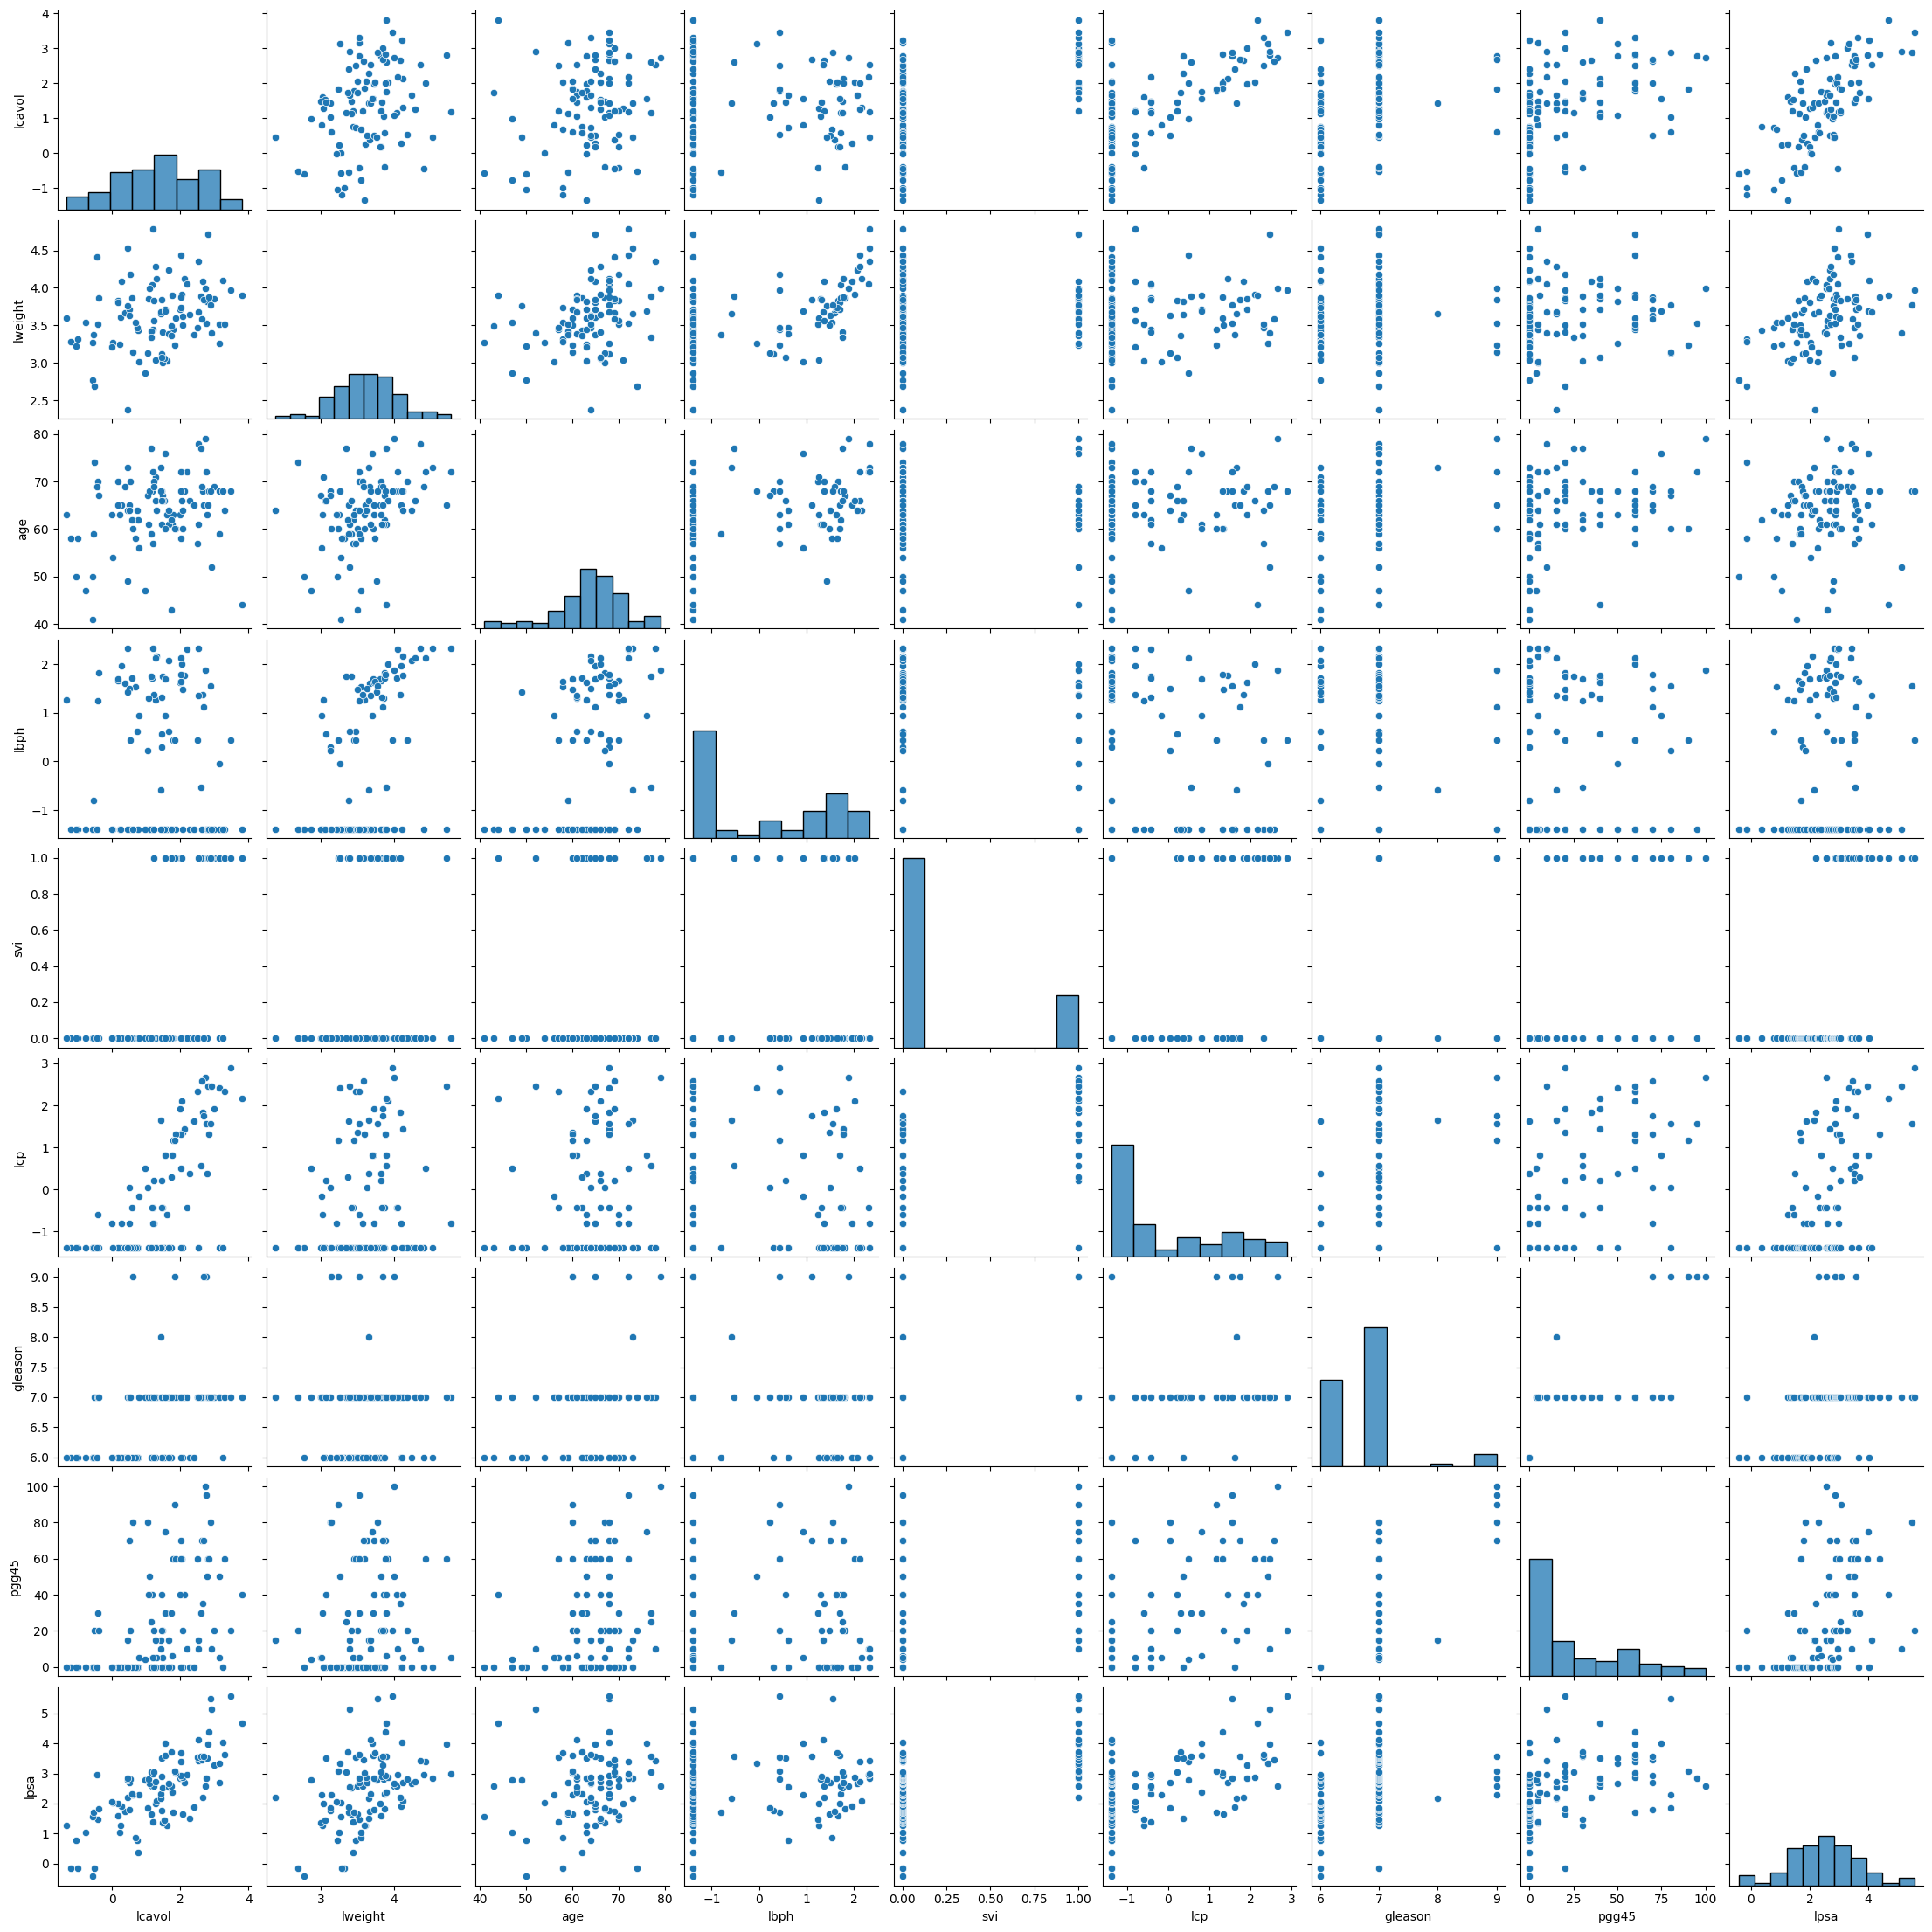

In [4]:
sns.pairplot(lpsa_data);

* El LSPA se distribuye casi normalmente.
* La presencia de SVI es binaria
* LCP: Debido a mediciones inadecuadas, para valores pequeños de penetración capsular, se ha establecido arbitrariamente en -1,25.
* Gleason y PGG45 no parecen estar correlacionados...

Veamos la correlación entre variables.

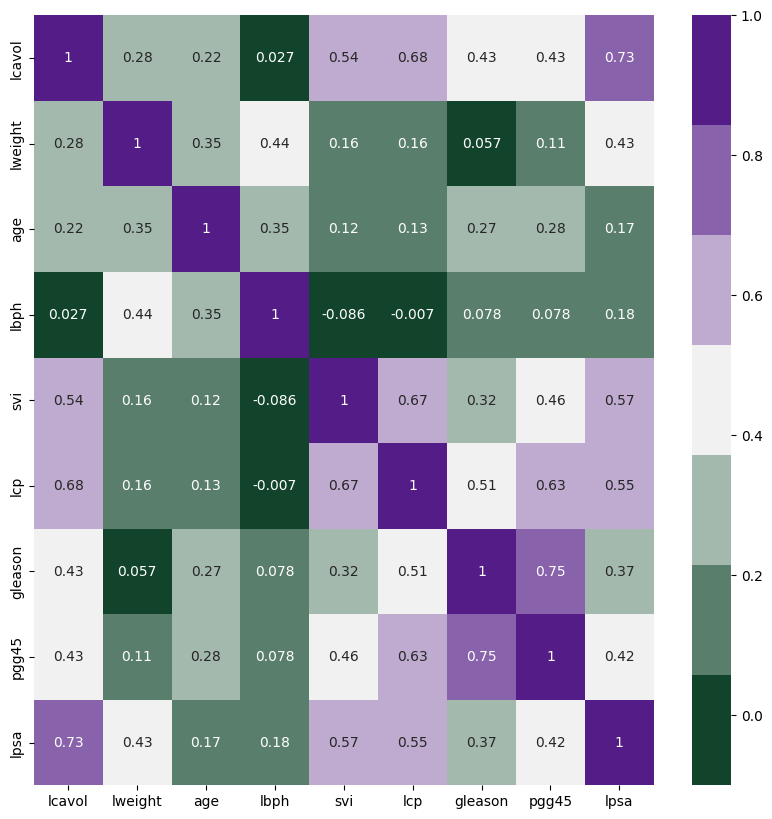

In [5]:
#### CODE
# sns.diverging_palette(145, 280, s=85, l=25, n=7)
plt.figure(figsize=(10,10))
sns.heatmap(lpsa_data.corr(),
           vmin=-0.1,
           vmax=1,
           cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True);

* La variable más correlacionada con la respuesta lpsa es lcavol.
  Por lo tanto, en un análisis de datos, la variable lcavol debe incluirse como predictor.

* La matriz de correlación muestra que gleason y pgg45 están realmente correlacionados. 
  De hecho, la variable pgg45 mide el porcentaje de 4 o 5 puntuaciones de Gleason que se registraron antes de la puntuación final de Gleason actual.

Vamos a trazar la relación entre la respuesta lpsa y la característica lcavol.

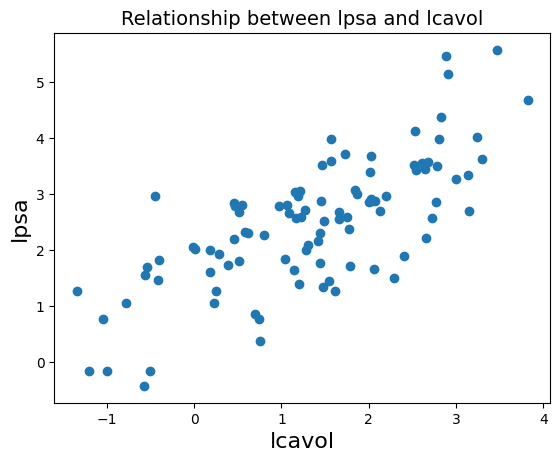

In [6]:
plt.scatter(lpsa_data['lcavol'], lpsa_data['lpsa'])
plt.xlabel('lcavol', fontsize=16)
plt.ylabel('lpsa', fontsize=16)
plt.title("Relationship between lpsa and lcavol", fontsize=14)
plt.show()

Existe una relación lineal bastante clara con la correlación positiva, como se ve en la matriz de correlación.

### Data train/test splitting

In [7]:
lpsa_data.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


In [8]:
# train : the first rows 
# test : the last rows 
n_split = 60
X_train = lpsa_data.iloc[:n_split,0:-2] # without pgg45
X_test = lpsa_data.iloc[n_split:,0:-2]
y_train = lpsa_data.iloc[:n_split,-1] # lpsa column
y_test = lpsa_data.iloc[n_split:,-1]  # lpsa column

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60, 7)
(37, 7)
(60,)
(37,)


# Modelos de aprendizaje

# 1) Línea base de regresión lineal

La regresión lineal intenta modelar la relación entre las variables predictoras $X$ y la variable de respuesta $y$.
Consiste en encontrar una función lineal $f:\mathbb{R}^p \to \mathbb{R}$ que predice la respuesta $y_i$ a partir de los predictores $X_{i1},...,X_{ip}$ dadas $n$ observaciones para $i=1,...,n$.


En Python, la regresión lineal se implementa como [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) en el módulo linear_model de scikit-learn.

In [10]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))

Train MSE: 0.2877748864599949
Test MSE: 2.864149965701442


# 2) Regularización

Con el fin de evitar el sobreaprendizaje, el método de regularización permite controlar la complejidad del modelo.
El modelo minimiza el error más un término de regularización $\lambda Reg(\beta)$ que mide la complejidad, donde $Reg(\beta)$ es un término de penalización y $\lambda$ es un hiperparámetro.
El hiperparámetro controla la influencia relativa del término de error y la cantidad de regularización.
El valor óptimo de $lambda$ se puede encontrar mediante validación cruzada (consulte el repositorio [validación cruzada](https://github.com/christelle-git/cross-validation/)).

## 2.1) Regresión de cresta 

En la regresión de Ridge, el término de regularización es $Reg(\beta) = ||\beta||_2^2$.
La regresión de Ridge permite reducir la magnitud de los pesos $\beta_i$ de la regresión lineal, y así evitar el sobreaprendizaje.
La regresión de Ridge tiene un efecto de selección agrupada: las variables correlacionadas tienen los mismos pesos.

In [11]:
from sklearn.linear_model import Ridge

ridgeR = Ridge(alpha = 10)
ridgeR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))

print("Train MSE:", round(metrics.mean_squared_error(y_train, ridgeR.predict(X_train)),2))
print("Test MSE:", round(metrics.mean_squared_error(y_test, ridgeR.predict(X_test)),2))
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, ridgeR.predict(X_test))))

Train MSE sin regularización: 0.29
Test MSE sin regularización: 2.86
Train MSE: 0.32
Test MSE: 2.07


In [12]:
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) 

coef_ridge = []
err_ridge = []
baseline = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    
    coef_ridge.append(ridge.coef_)
    
    y_pred = ridge.predict(X_test)
    ridge_error = metrics.mean_squared_error(y_pred, y_test)
    
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

In [13]:
min(err_ridge)

2.0650575013210712

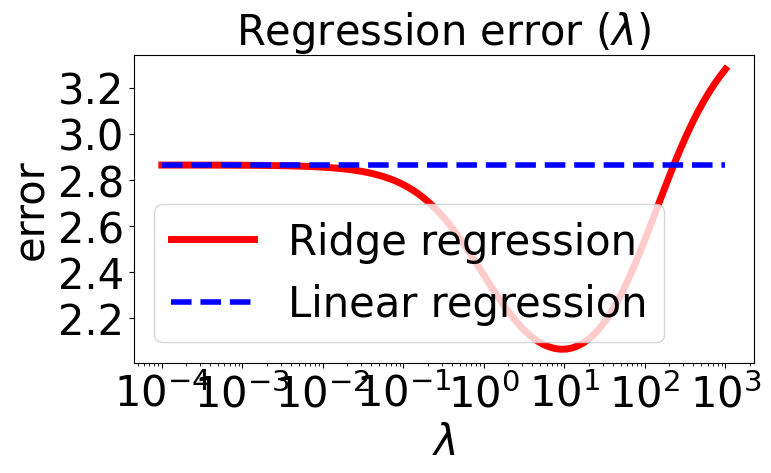

In [33]:
plt.figure(figsize=(8,4))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [15]:
from sklearn.linear_model import Ridge 
  
# Train the model  
ridgeR = Ridge(alpha = 10) 
ridgeR.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, ridgeR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, ridgeR.predict(X_test)))

Train MSE: 0.3160
Test MSE: 2.0651


* El valor óptimo del coeficiente de regularización $\lambda$ es de alrededor de 10.
* Para $\lambda \to 0$ los términos de regularización desaparecen, lo que lleva al mismo resultado que la regresión lineal.
* Para $\lambda \to \infty$ domina la magnitud del término de regularización.

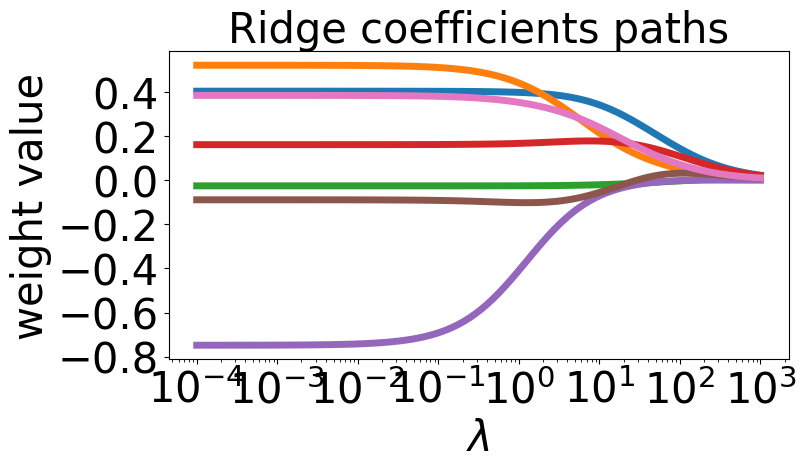

In [32]:
plt.figure(figsize=(8,4))
ax = plt.gca()
ax.plot(alphas, coef_ridge, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Ridge coefficients paths', fontsize=30)
plt.show()

* La regresión de cresta restringe algunas variables reduciendo la magnitud de sus pesos.

## 2.2) Operador de selección y contracción mínima absoluta

El siguiente método va más allá al seleccionar algunas variables que se eliminarán de la regresión de Ridge, reduciendo así la dimensión.
El método se denomina Operador de Selección y Contracción Mínima Absoluta (Lasso) y el modelo simplificado resultante es un **modelo disperso** o modelo parsimonioso.
En el lazo, el término de regularización se define por $Reg(\beta) = ||\beta||_1$.

El lazo realiza la selección de características de un modelo: para las variables correlacionadas, retiene solo una variable y establece otras variables correlacionadas en cero.
La contrapartida es que obviamente induce una pérdida de información que resulta en una menor precisión.

In [17]:
from sklearn.linear_model import Lasso

lassoR = Lasso(alpha=10)
lassoR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

Train MSE sin regularización: 0.29
Test MSE sin regularización: 2.86
Train MSE: 0.6469
Test MSE: 3.5802


In [18]:
lasso = linear_model.Lasso(fit_intercept=False)

coef_lasso = []
err_lasso = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(X_test)
    lasso_error = metrics.mean_squared_error(y_pred, y_test)    
    err_lasso.append(lasso_error)

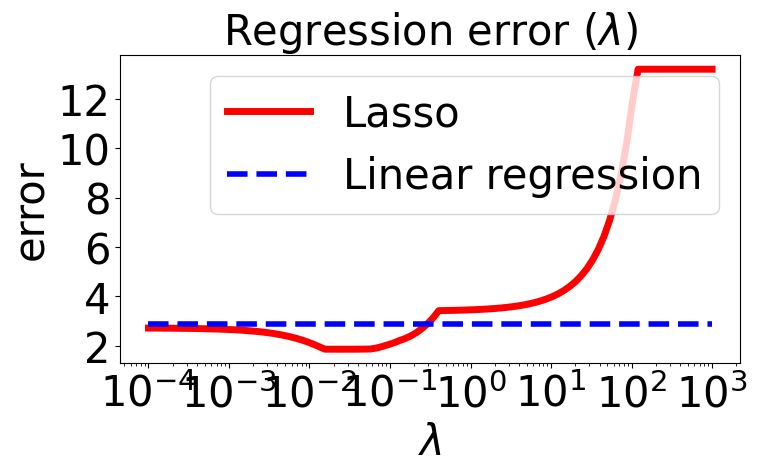

In [34]:
plt.figure(figsize=(8,4))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [20]:
lassoR = Lasso(alpha = 0.02) 
lassoR.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

Train MSE: 0.3061
Test MSE: 1.8514


In [21]:
print("Test MAPE: %0.4f" % metrics.mean_absolute_percentage_error(y_test, lassoR.predict(X_test)))

Test MAPE: 0.3103


* El valor óptimo del coeficiente de regularización $lambda$ está entre $10^{-2}$ y $10^{-1}$.
* Para $\lambda \to 0$ los términos de regularización desaparecen, por lo que la regresión de Lasso tiende a la regresión lineal.
* Para $\lambda \to \infty$ la magnitud del término de regularización domina el error.

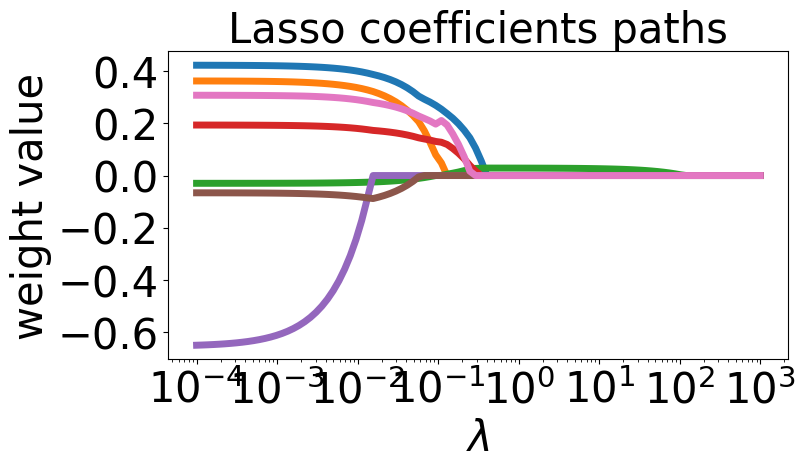

In [35]:
plt.figure(figsize=(8,4))
ax = plt.gca()
ax.plot(alphas, coef_lasso, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Lasso coefficients paths', fontsize=30)
plt.show()

* El Lazo elimina algunas variables poniendo su peso a cero. <br>
  Este es el caso si dos variables están correlacionadas.
* A medida que los pesos de $lambda to infty$ desaparecen, el modelo se vuelve muy **escaso**.

## 2.3) Red elástica

El método Elastic Net es un híbrido de la regresión Ridge y el Lasso, superando así el problema de la pérdida de información.
El término de regularización combina las regularizaciones $L_1$ y $L_2$.
Más precisamente, el término de regularización se establece en $Reg(\beta) = \lambda((1-\alpha)||\beta||_1+\alpha||\beta||_2^2)$ donde $\alpha$ es un parámetro adicional para ajustar.

La red elástica tiene un efecto de selección en las variables como lazo, pero mantiene las variables correlacionadas como regresión de cresta.

In [23]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 1, l1_ratio = 0.5)
elastic_net.fit(X_train, y_train)

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))

Train MSE: 0.6375
Test MSE: 3.5183


In [24]:
np.random.randint(0,1,100)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
coef_eln = []
err_eln = []
baseline = []
for a in alphas:
    elastic_net = ElasticNet(alpha = a, l1_ratio=1)
    elastic_net.fit(X_train, y_train)
    coef_eln.append(elastic_net.coef_)
    y_pred = elastic_net.predict(X_test)
    elasticnet_error = metrics.mean_squared_error(y_pred, y_test)
    err_eln.append(elasticnet_error)
    baseline.append(baseline_error)
    

In [26]:
min(err_eln)

1.8512304850728976

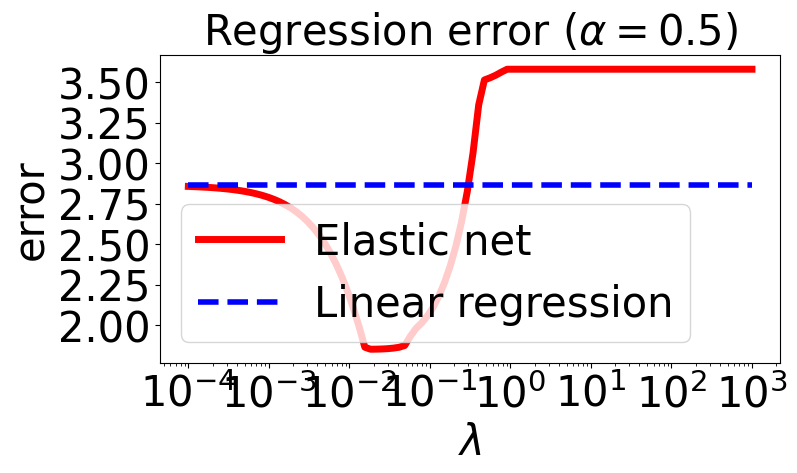

In [36]:
plt.figure(figsize=(8,4))
ax = plt.gca()
ax.plot(alphas, err_eln, linewidth=5, color='red', label="Elastic net")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\alpha=0.5$)', fontsize=30)
plt.show()

In [28]:
elastic_net = ElasticNet(alpha = 0.025, l1_ratio=1)
elastic_net.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))

Train MSE: 0.3096
Test MSE: 1.8526


* El valor óptimo del coeficiente de regularización $lambda$ está entre $10^{-2}$ y $10^{-1}$.
* Para $\lambda \to 0$ los términos de regularización desaparecen, lo que lleva al mismo resultado que la regresión lineal.
* Para $\lambda \to \infty$ la magnitud del término de regularización domina el error, que es menor que con el Lasso.

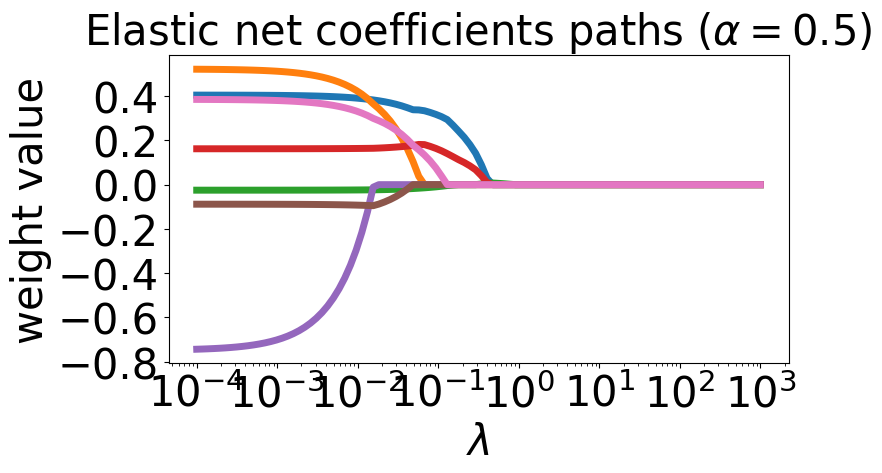

In [37]:
plt.figure(figsize=(8,4))
ax = plt.gca()
ax.plot(alphas, coef_eln, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title(r'Elastic net coefficients paths ($\alpha=0.5$)', fontsize=30)
plt.show()

* Como era de esperar, la red elástica mantiene más variables que el lazo.
* Se puede obtener un mejor rendimiento variando el valor del hiperparámetro $alpha$.


<br>

# Model selection 

In [30]:
print("Linear regression error:   %0.4f" % baseline_error)    
print("Minimun ridge error:       %0.4f" % min(err_ridge))
print("Minimum lasso error:       %0.4f" % min(err_lasso))
print("Minimum elastic net error: %0.4f" % min(err_eln))

Linear regression error:   2.8641
Minimun ridge error:       2.0651
Minimum lasso error:       1.8531
Minimum elastic net error: 1.8512


* El Lazo funciona mejor que otros métodos (Red elástica: $alpha=0.5$). 
* El lazo es más parsimonioso, pero es probable que haya una pérdida de precisión.
* La red elástica funciona mejor que la regresión de cresta (con $alpha=0.5$).
* La red elástica se puede ajustar para superar a Lasso, pero es más exigente en recursos computacionales.

**=> La red elástica es una buena compensación para la precisión y el equilibrio de costos computacionales entre la regresión de Ridge y el lazo**.


Con el fin de optimizar el modelo ajustando los parámetros óptimos, se puede realizar una validación cruzada.
Las funciones sklearn.linear_model. RidgeCV, sklearn.linear_model. LassoCV y sklearn.linear_model. ElasticNetCV en Python realiza un ajuste automático de hiperparámetros para la regresión de Rigde, el Lazo y la Red Elástica respectivamente.